In [215]:
# # %pwd
# %cd drive/MyDrive/'stuff after the mission'/'Fall 23'/'ECEN 758'

In [1]:
import data_loader_utility as dlu
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_dl, test_dl, val_dl = dlu.get_dataloaders()

In [4]:
X_train, X_test, y_train, y_test = dlu.get_tabular_data()

## 2 (a) Descriptive Statistics (e.g., class distributions, data statistics)

In [220]:
from matplotlib.ticker import MaxNLocator

Text(0, 0.5, '% of dataset made up by each class')

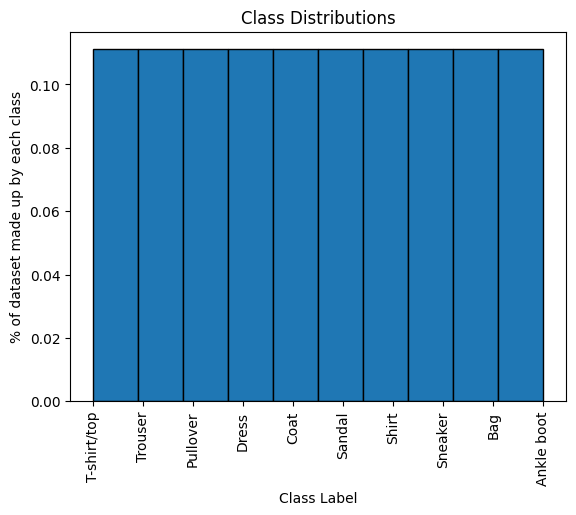

In [221]:
all_labels = np.concatenate([np.array(X_test), np.array(y_test)])
fig, ax = plt.subplots()
ax.hist(all_labels, density=True, edgecolor='black')
ax.set_title('Class Distributions')
ax.set_xlabel('Class Label')
ax.set_xticks(ticks=list(dlu.label_dict.keys()),  # TODO -- FIX THE XTICKS/LABELS
              labels=list(dlu.label_dict.values()),
              rotation=90)
ax.set_ylabel('% of dataset made up by each class')

## Use a pretrained ResNet50 neural network to create a feature vector for each image to use to train an XGBoost model

###### References: https://stackoverflow.com/questions/55083642/extract-features-from-last-hidden-layer-pytorch-resnet18

In [222]:
# from torchvision import models
# rn50 =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # children_counter = 0
# # for n,c in rn50.named_children():
# #     print("Children Counter: ",children_counter," Layer Name: ",n,)
# #     children_counter+=1

In [223]:
# feature_extractor = torch.nn.Sequential(*list(rn50.children())[:-1])

In [224]:
# import torch.nn as nn
# class CustomResNet50(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomResNet50, self).__init()
#         # Load the pre-trained ResNet-50 model
#         self.resnet50 = models.resnet50(pretrained=True)

#         # Modify the first layer to accept 28x28 images
#         self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#         # Modify the average pooling layer to adapt to the new input size
#         self.resnet50.avgpool = nn.AdaptiveAvgPool2d(1)

#         # Modify the final fully connected layer to match the number of output classes
#         self.resnet50.fc = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         return self.resnet50(x)


In [225]:
# x = torch.randn([1,3,27,27])
# custom_resnet = CustomResNet50(num_classes=10)

In [226]:

# x = torch.randn([1,3,27,27])
# # output = feature_extractor(x)
# # output.to(device)

In [227]:
# train_dl, test_dl, val_dl = dlu.get_dataloaders('data/fashion')

In [228]:
device

'cpu'

Building a model based on this model [here](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/).

In [5]:
# import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1)  # review wht the different channels are (andrew ng)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(28, 14, kernel_size=3, stride=1, padding=1)  # default padding is 0, so we need to specify 1 to get the dimensions we want
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # new convolutionl layer
        # self.conv3 = nn.Conv2d(14, 7, kernel_size=3, stride=1, padding=1)
        # self.act3 = nn.ReLU()
        # self.pool3 = nn.MaxPool2d(kernel_size=2)

        # batchnorm dded
        # self.bn1 = nn.BatchNorm2d()  # how does this value affect the later layers, accuracy, etc.?

        self.flat = nn.Flatten()
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x3388 and 343x343)
        self.fc4 = nn.Linear(14*7*7, 343)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(343, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        # print(x.shape, 'original')
        x = self.act1(self.conv1(x))
        # print(x.shape, 'after first conv and before 1st maxpool')
        x = self.pool1(x)
        # print(x.shape, 'after 1st maxpool')
        # x = self.drop1(x)
        # print(x.shape, 'after dropout')
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # print(x.shape, 'after 2nd conv')
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # print(x.shape, 'after 2nd maxpool')
        # new conv layer
        # x = self.act3(self.conv3(x))
        # print(x.shape, 'after 3rd conv')
        # x = self.pool3(x)
        # print(x.shape, 'after 2nd pool')
        # input 32x16x16, output 8192
        x = self.flat(x)
        # print(x.shape, 'after flattening')
        # input 8192, output 512
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # print(x.shape, 'after last dropout layer')
        # input 512, output 10
        x = self.fc5(x)
        # print(x.shape, 'last shape after nn.Linear(343, 10)\n\n')
        return x


In [7]:
### TODO -- get the features out
### TODO -- fit an xgboost model
### TODO -- inspect the model performance metrics
### TODO -- tey out-of-sample predictions

model_ = HomemadeCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=0.001, momentum=0.9)

n_epochs = 30  # experiment with adjusting this
for epoch in range(n_epochs):
    for inputs, labels in train_dl:
        # forward, backward, and then weight update
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)#.to(device)
        loss = loss_fn(y_pred, labels)

        # double check what these are doing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in val_dl:
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))



In [ ]:
# torch.save(model_.state_dict(), "homemademodel.pth")

In [ ]:
acc = 0
count = 0

with torch.no_grad():
    for inputs, labels in test_dl:
        labels = labels.to(device)
        inputs = inputs.to(device)
        y_pred = model_(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)

In [ ]:
acc / count  # 90%!! not bad :) - need to vet that though

tensor(0.9003)

## Extract features from the CNN by specifying which layer to extract them from
We can use code from [here](https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5) to build a feature extractor from our model and use that to get the output of a given layer of our model when it passes over an image.

In [43]:
trained = HomemadeCNN()
trained.load_state_dict(torch.load('homemademodel.pth'))
trained.eval()

HomemadeCNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=686, out_features=343, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=343, out_features=10, bias=True)
)

In [44]:
# load an image to play around with
imgs, labels = next(iter(train_dl))
# plt.imshow(imgs[1].reshape(28,28), cmap='gray')
feat_map_gen_img = imgs[1] #.reshape(28,28)
feat_map_gen_img = feat_map_gen_img.to(device)

In [253]:
# THIS WORKS HERE!!
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# model = ()
trained = HomemadeCNN()
trained.load_state_dict(torch.load('homemademodel.pth'))  # include this! bc that includes the weights (?)
trained.fc4.register_forward_hook(get_activation('fc4'))
output = trained(imgs)  # add unsqueeze to get it into the right shape (add a batch dimension of 1)

In [267]:
num_features = 343  # equivalent to the number of features being output by the selected layer; update as needed
# you should be able to check the .txt file for information on what size it needs to be if you change the layer (i.e., to 'flat' or one of the conv layers)
num_rows = 50016

cnn_features = torch.zeros((num_rows, num_features))  # dim1 = the number of images in the train dataset; 343 = number of outputs for the layer we selected
labels_ = np.zeros(num_rows)  # initializing a matrix of zeros to fill (should be faster than appending rows one by one to a matrix and growing it on each iteration?)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

trained = HomemadeCNN()
trained.load_state_dict(torch.load('homemademodel.pth'))  # include this! bc that includes the weights (?)
trained.fc4.register_forward_hook(get_activation('fc4'))
# output = trained(imgs)  # add unsqueeze to get it into the right shape (add a batch dimension of 1)
trained = trained.to(device)

index = 0
for inputs, labels in train_dl:
    labels = labels.to(device)
    # print(labels)
    inputs = inputs.to(device)
    outputs = trained(inputs)
    # labels_[index:index + len(labels)] = labels
    for i in range(0, outputs.shape[0]):
        print(outputs[i])
        print(outputs[i].detach().shape)
        bruhh = activation['fc4']
        cnn_features[index, :] = outputs[i]
        index += 1

    # for i in range(0, activation['fc4'].shape[0]):
    #     cnn_features[index,:] = activation['fc4'][i]
    #     index += 1

tensor([-2.9936, -2.8179, -3.0156, -3.6202, -7.8479,  3.8571, -5.5921, 10.6702,
        -3.4778, 11.5991], grad_fn=<SelectBackward0>)
torch.Size([10])


RuntimeError: The expanded size of the tensor (343) must match the existing size (10) at non-singleton dimension 0.  Target sizes: [343].  Tensor sizes: [10]

In [273]:
# This here appends the same row of the weights over and over lol. it does not work. 


num_features = 343  # equivalent to the number of features being output by the selected layer; update as needed
# you should be able to check the .txt file for information on what size it needs to be if you change the layer (i.e., to 'flat' or one of the conv layers)
num_rows = 50016

cnn_features = np.zeros((num_rows, num_features))  # dim1 = the number of images in the train dataset; 343 = number of outputs for the layer we selected
labels_ = np.zeros(num_rows)
# initialize a matrix of zeros to fill (should be faster than appending rows one by one to a matrix and growing it on each iteration?)
trained.fc4.register_forward_hook(get_activation('fc4'))
# trained = trained.to(device)
index = 0
for inputs, labels in train_dl:
    labels = labels.to(device)
    # print(labels)
    inputs = inputs.to(device)
    # labels_[index:index + len(labels)] = labels
    for i in range(0, activation['fc4'].shape[0]):
        cnn_features[index,:] = activation['fc4'][i]
        index += 1

In [92]:
# gets all the labels from the dataloader
other_index = 0
for inputs, labels in train_dl:
    labels = labels.to(device)
    for lab in labels:
        # print(lab)
        labels_[other_index] = float(lab)
        other_index += 1
        # print(lab)

In [274]:
# will currently just create a data matrix of weights - not useful
synthetic_features = pd.DataFrame(cnn_features[0:50000,:])
labels_ = pd.Series(labels_[0:50000])

In [83]:
# # create a function so that we can easily try the output from different layers!
# def load_model(path_to_model: str):
#     # load model
#     trained_ = HomemadeCNN()
#     trained_.load_state_dict(torch.load(path_to_model))
#     return trained_#.eval()


# def get_intermediate_outputs(what_layer, layer_id: str, feature_shape: tuple, label_shape: int):


#     # get the activation stuff from within the model
#     activation_ = {}
#     def get_activation_(name):
#         def hook(model, input, output):
#             activation_[name] = output.detach()
#         return hook


#     # num_features = num_features  # equivalent to the number of features being output by the selected layer; update as needed
#     # # you should be able to check the .txt file for information on what size it needs to be if you change the layer (i.e., to 'flat' or one of the conv layers)
#     # num_rows = num_rows

#     cnn_features_ = torch.zeros(feature_shape)  # dim1 = the number of images in the train dataset; 343 = number of outputs for the layer we selected
#     label_names = torch.zeros((label_shape, 1))
#     # initialize a matrix of zeros to fill (should be faster than appending rows one by one to a matrix and growing it on each iteration?)
#     what_layer.register_forward_hook(get_activation_(layer_id))
#     # trained = trained.to(device)
#     index_ = 0
#     for inputs_, label_ in train_dl:
#         label_ = label_.to(device)
#         # print(labels)
#         inputs_ = inputs_.to(device)
#         # labels_[index:index + len(labels)] = labels
#         for i in range(0, activation_[layer_id].shape[0]):
#             cnn_features_[index_,:] = activation_[layer_id][i]
#             index_ += 1

#         other_index_ = 0
#             # label_s = label_s.to(device)
#         for lab in label_:
#             # print(lab)
#             label_names[other_index_] = float(lab)
#             other_index_ += 1

#     # for inputs_, label_s in train_dl:
#     #         # print(lab)

## Fit models with the outputs of the CNN
Using the "synthetic" features generated by the CNN, we can now fit traditional ML models. It would be worthwhile to experiment with taking the outputs from other layers and see how it affects the performance of these models. 

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

Fit a Random Forest classifier to the synthetic features and compare its performance to performance on the unprocessed image data ($343 \times n$), where $n = $ the number of rows in the training set.

accuracy:  0.09944


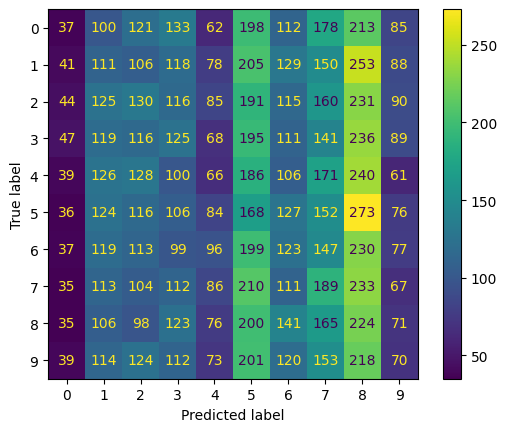

In [94]:
def random_forest(xtrain, xtest, ytrain, ytest):
    """Fit a random forest classifier and display accuracy and confusion matrix."""
    np.random.seed(64)

    rfc = RandomForestClassifier()
    rfc.fit(xtrain, ytrain)
    rf_preds = rfc.predict(xtest)

    # check performance
    print('accuracy: ', metrics.accuracy_score(ytest, rf_preds))
    confmat_rf = metrics.confusion_matrix(ytest, rf_preds)
    show_confmat_rf = metrics.ConfusionMatrixDisplay(confmat_rf)
    show_confmat_rf.plot()
    plt.show()


X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(synthetic_features, labels_,
                                                            test_size=.25, random_state=64)



random_forest(X_train_s, X_test_s, y_train_s, y_test_s)

Basically, it kind of sucks when we get data from the `fc4` layer. Let's see how it does when training the same model on pixel brightness values for the original dataset.

accuracy:  0.876


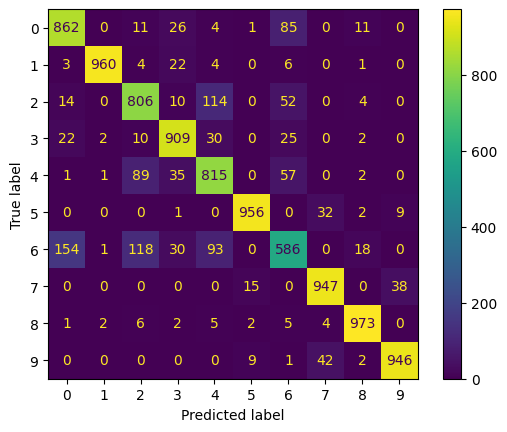

In [88]:
random_forest(X_train, y_train, X_test, y_test)

In [89]:
# load model
trained = HomemadeCNN()
trained.load_state_dict(torch.load('homemademodel.pth'))
trained.eval()

HomemadeCNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=686, out_features=343, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=343, out_features=10, bias=True)
)

In [ ]:

# get the activation stuff from within the model
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


num_features = 343  # equivalent to the number of features being output by the selected layer; update as needed
# you should be able to check the .txt file for information on what size it needs to be if you change the layer (i.e., to 'flat' or one of the conv layers)
num_rows = 50016

cnn_features = np.zeros((num_rows, num_features))  # dim1 = the number of images in the train dataset; 343 = number of outputs for the layer we selected
labels_ = np.zeros(num_rows)
# initialize a matrix of zeros to fill (should be faster than appending rows one by one to a matrix and growing it on each iteration?)
trained.conv2.register_forward_hook(get_activation('conv2'))
# trained = trained.to(device)


# index = 0
# for inputs, labels in train_dl:
#     labels = labels.to(device)
#     # print(labels)
#     inputs = inputs.to(device)
#     # labels_[index:index + len(labels)] = labels
#     for i in range(0, activation['conv2'].shape[0]):
#         cnn_features[index,:] = activation['conv2'][i]
#         index += 1

# other_index = 0
# for inputs, labels in train_dl:
#     labels = labels.to(device)
#     for lab in labels:
#         # print(lab)
#         labels_[other_index] = float(lab)
#         other_index += 1
        # print(lab)